In [1]:
import pandas as pd
import numpy as np
import math
import glob
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from multiprocessing import Pool
seed = 42

In [ ]:
with Pool(50) as p:
    samples = pd.concat(p.map(pd.read_csv, glob.glob('./outputs/ibm_net_series/*.csv')))
samples = samples.reset_index(drop=True)

In [ ]:
samples = samples.drop(samples[samples.EIR == -1].index).reset_index(drop=True)

In [ ]:
samples = samples.drop(samples[np.isnan(samples.EIR)].index).reset_index(drop=True) # NOTE: investigate why EIR is NaN

In [ ]:
output_columns = [name for name in samples.columns if 'prev_' in name]
outputs = samples[output_columns]
month = [p.month for p in (pd.Period('2000-01-01') + np.arange(len(output_columns)))]
year = [year for year in range(len(output_columns) // 365) for _ in range(365)]
outputs = outputs.groupby(by=[year, month], axis=1).mean()
ts_columns = [name for name in samples.columns if 'itn_usage_' in name]
features = samples.drop(labels=output_columns + ts_columns + ['init_EIR'], axis=1)
ts_features = np.zeros_like(outputs)
ts_features[:, range(0, ts_features.shape[1], 12)] = samples[ts_columns]
n_features = len(features.columns)
n_ts_features = len(ts_columns)
n_outputs = len(outputs.columns)

In [ ]:
idx_train, idx_test = train_test_split(
    np.arange(len(outputs)), #np.arange(100000),
    test_size=0.2,
    random_state=seed
)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
tf.config.run_functions_eagerly(True)

2022-11-25 13:48:15.265318: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 13:48:15.815628: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
X_train = features.iloc[idx_train]
X_seq_train = ts_features[idx_train, :, np.newaxis]
y_train = outputs.to_numpy()[idx_train, :, np.newaxis]
X_test = features.iloc[idx_test]
X_seq_test = ts_features[idx_test, :, np.newaxis]
y_test = outputs.to_numpy()[idx_test, :, np.newaxis]

scaler = layers.Normalization()
scaler.adapt(X_train.to_numpy())

2022-11-25 13:48:19.161257: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 13:48:21.127149: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38406 MB memory:  -> device: 0, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:27:00.0, compute capability: 8.0
2022-11-25 13:48:21.146942: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38406 MB memory:  -> device: 1, name: NVIDIA A100-PCIE-40GB, pci bus id: 0000:28:00.0, compute capability: 8.0


In [16]:
from fastms.attention import LuongAttention, AttentionDecoder

In [22]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam

class RepeatLayer(layers.Layer):

    def call(self, inputs):
        static, seq = inputs
        return tf.repeat(static[:, np.newaxis, :], K.shape(seq)[1], axis=1)

def create_attention_model(
    optimiser='adam',
    units=128,
    dropout=0.,
    loss='log_cosh',
    hidden_activation='relu',
    hidden_initialiser='he_normal',
    output_activation='linear',
    output_initialiser='glorot_normal',
    output_units=y_train.shape[2],
):
    input_layer = Input(shape=n_features, dtype='float32')
    seq_input = Input(shape=(None, 1), dtype='float32')
    static_input = scaler(input_layer)
    static_input_ts = static_input[:, np.newaxis, :]
    repeated_static_input = RepeatLayer()([static_input, seq_input])
    encoder_input = layers.Concatenate()(
        [seq_input, repeated_static_input]
    )

    encoder_output, h, c = layers.LSTM(
        units,
        return_sequences=True,
        return_state=True
    )(encoder_input)
        
    decoder = AttentionDecoder(
        units,
        output_units,
        layers.LSTM,
        LuongAttention,
        [output_activation],
        [output_initialiser]
    )
    output, attention, state = decoder(encoder_input, encoder_output, [h, c])
    model = Model(inputs = [input_layer, seq_input], outputs = [output])
    model.compile(loss=loss, optimizer=optimiser, metrics='mse')
    return model

In [23]:
model = create_attention_model()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 31)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, None, 1)]    0           []                               
                                                                                                  
 normalization (Normalization)  (None, 31)           63          ['input_9[0][0]']                
                                                                                                  
 repeat_layer_6 (RepeatLayer)   (None, None, 31)     0           ['normalization[4][0]',          
                                                                  'input_10[0][0]']         

In [24]:
model.fit((X_train, X_seq_train), y_train, batch_size=100, epochs=100)

Epoch 1/100


2022-11-25 14:04:33.150244: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-PCIE-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40271806464 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


572/572 [==============================] - 19s 26ms/step - loss: 0.0032 - mse: 0.0065
Epoch 2/100
572/572 [==============================] - 14s 25ms/step - loss: 0.0018 - mse: 0.0036
Epoch 3/100
572/572 [==============================] - 14s 25ms/step - loss: 0.0014 - mse: 0.0029
Epoch 4/100
572/572 [==============================] - 14s 24ms/step - loss: 9.0525e-04 - mse: 0.0018
Epoch 5/100
572/572 [==============================] - 14s 25ms/step - loss: 6.1507e-04 - mse: 0.0012
Epoch 6/100
572/572 [==============================] - 15s 25ms/step - loss: 4.7190e-04 - mse: 9.4492e-04
Epoch 7/100
572/572 [==============================] - 15s 26ms/step - loss: 3.9436e-04 - mse: 7.8954e-04
Epoch 8/100
572/572 [==============================] - 14s 25ms/step - loss: 3.2487e-04 - mse: 6.5033e-04
Epoch 9/100
572/572 [==============================] - 15s 26ms/step - loss: 2.8398e-04 - mse: 5.6844e-04
Epoch 10/100
572/572 [==============================] - 15s 25ms/step - loss: 2.3730e-04 -

In [25]:
y_hat = model.predict((X_test, X_seq_test))

2022-11-25 14:28:44.192135: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:690] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "GPU" vendor: "NVIDIA" model: "NVIDIA A100-PCIE-40GB" frequency: 1410 num_cores: 108 environment { key: "architecture" value: "8.0" } environment { key: "cuda" value: "11020" } environment { key: "cudnn" value: "8100" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 41943040 shared_memory_size_per_multiprocessor: 167936 memory_size: 40271806464 bandwidth: 1555200000 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


447/447 [==============================] - 7s 12ms/step


Text(0, 0.5, 'true')

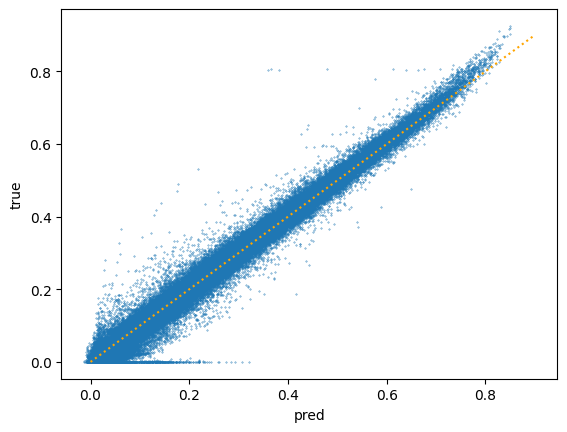

In [26]:
plt.scatter(y_hat.flatten(), y_test.flatten(), s=0.1)
plt.plot(np.linspace(0, 0.9), np.linspace(0, 0.9), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

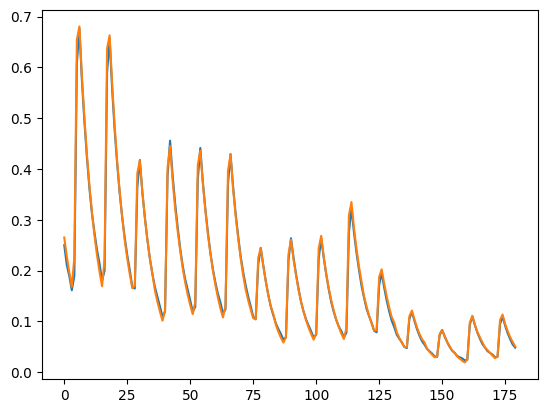

In [27]:
i = 1001
plt.plot(range(180), y_hat[i,:,0])
plt.plot(range(180), y_test[i,:,0])

In [12]:
import keras_tuner as kt

In [13]:
def bulid_hypermodel(hp):
    return create_model(
        n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, step=1),
        units = hp.Int("units", min_value=32, max_value=512, step=32),
        dropout = hp.Float("dropout", min_value=0., max_value=.2, step=.01),
        loss = hp.Choice("loss", ['mse', 'log_cosh']),
        hidden_activation = hp.Choice("hidden_activation", ['relu', 'elu']),
        output_activation = hp.Choice("output_activation", ['linear', 'softmax'])
    )

In [14]:
tuner = kt.Hyperband(
    hypermodel=bulid_hypermodel,
    objective="val_mse",
    max_epochs=100,
    seed=42,
    overwrite=True,
    directory="hyperparameters",
    project_name="det",
)

In [15]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
n_hidden (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 5, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.2, 'step': 0.01, 'sampling': None}
loss (Choice)
{'default': 'mse', 'conditions': [], 'values': ['mse', 'log_cosh'], 'ordered': False}
hidden_activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
output_activation (Choice)
{'default': 'linear', 'conditions': [], 'values': ['linear', 'softmax'], 'ordered': False}


In [16]:
X_hyp_train, X_hyp_val, y_hyp_train, y_hyp_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=seed
)

In [17]:
tuner.search(
    X_hyp_train,
    y_hyp_train,
    validation_data=(X_hyp_val, y_hyp_val),
    callbacks=[tf.keras.callbacks.EarlyStopping("mse", min_delta=1e-10, patience=5)]
)

Trial 230 Complete [00h 02m 17s]
val_mse: 0.00022005359642207623

Best val_mse So Far: 9.33476330828853e-05
Total elapsed time: 02h 25m 44s

Search: Running Trial #231

Value             |Best Value So Far |Hyperparameter
4                 |4                 |n_hidden
192               |96                |units
0.02              |0                 |dropout
mse               |mse               |loss
elu               |elu               |hidden_activation
linear            |linear            |output_activation
34                |100               |tuner/epochs
12                |34                |tuner/initial_epoch
2                 |4                 |tuner/bracket
1                 |4                 |tuner/round
0225              |0144              |tuner/trial_id

Epoch 13/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0174 - mse: 0.0174 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 14/34
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0023 - 

KeyboardInterrupt: 

623/623 [==============================] - 1s 1ms/step


Text(0, 0.5, 'true')

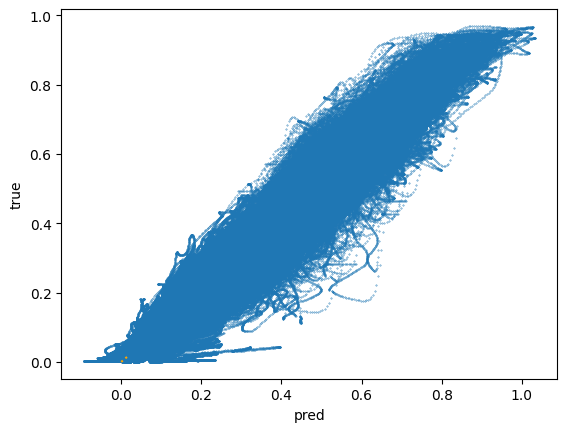

In [38]:
bm = tuner.get_best_models(num_models=1)[0]
y_hat = model.predict(X_test)
plt.scatter(y_hat.flatten(), y_test.to_numpy().flatten(), s=0.1)
plt.plot(np.linspace(0, 0.02), np.linspace(0, 0.02), linestyle=':', color='orange')
plt.xlabel('pred')
plt.ylabel('true')

In [39]:
tuner.results_summary()

Results summary
Results in hyperparameters/eq
Showing 10 best trials
Trial summary
Hyperparameters:
n_hidden: 4
units: 128
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.0011498170206323266
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.07
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch: 34
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0238
Score: 0.0012141329934820533
Trial summary
Hyperparameters:
n_hidden: 3
units: 192
dropout: 0.04
loss: mse
hidden_activation: relu
output_activation: linear
tuner/epochs: 34
tuner/initial_epoch: 12
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0219
Score: 0.0015096659772098064
Trial summary
Hyperparameters:
n_hidden: 3
units: 96
dropout: 0.09
loss: log_cosh
hidden_activation: elu
output_activation: linear
tuner/epochs: 100
tuner/initial_epoch:

In [30]:
model.save('models/det_sequence')

INFO:tensorflow:Assets written to: models/det_sequence/assets


INFO:tensorflow:Assets written to: models/det_sequence/assets
